In [2]:
import numpy as np
import pandas as pd
from IPython.core.pylabtools import figsize
from matplotlib.figure import figaspect
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS

In [3]:
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
    (RandomForestRegressor as RF,
     GradientBoostingRegressor as GBR)

In [4]:
Carseats = load_data('Carseats')
Carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [5]:
# Creates a variable called High which is yes when Sales is greater than 8 and No when Sales is less than 8
High = np.where(Carseats.Sales > 8,
                "Yes",
                "No")

In [6]:
# We now use the DecisionTreeClassifier function to fit a classification tree to predict High using all variables other than Sales
model = MS(Carseats.columns.drop('Sales'), intercept = False)
D = model.fit_transform(Carseats)

# We convert D from a dataframe to an array X, which we will use for analysis below.  We also need feature_names for annotating plots later on
feature_names = list(D.columns)
X = np.asarray(D)

In [7]:
# There are several options needed to specify the classifier, maxdepth = how deep to grow the tree, min_samples_split = minimum number of observations in a node to be eligible for splitting, and criterion = whether to use Gini or cross entropy as the split criterion.
clf = DTC(criterion = 'entropy',
          max_depth = 3,
          random_state = 0)
clf.fit(X, High)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [8]:
# With only the default arguments the wrong classification rate is 21%
accuracy_score(High, clf.predict(X))

0.79

In [9]:
# For classification trees this is how we calculate the deviance
resid_dev = np.sum(log_loss(High, clf.predict_proba(X)))
resid_dev
# A small deviance indicates a tree that provides a good fit to the training data

np.float64(0.47106470626493574)

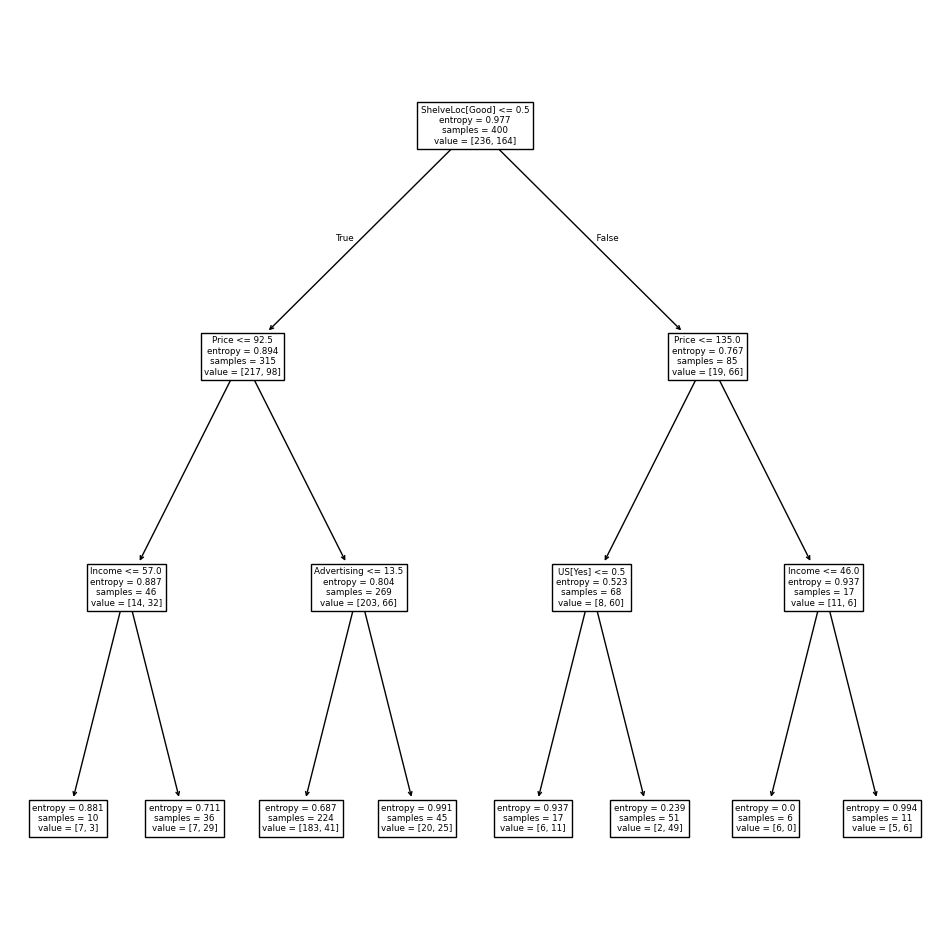

In [10]:
# Here we use the plot() function to display the tree structure, the argument feature_names instructs python to include the variable names rather than X1, X2, ...
ax = subplots(figsize = (12, 12))[1]
plot_tree(clf,
          feature_names = feature_names,
          ax = ax);

In [11]:
# We can see a text representation of the tree using export_text() with show_weights = True, which displays the path you would take to reach each terminal node
print(export_text(clf,
                  feature_names = feature_names,
                  show_weights = True))

|--- ShelveLoc[Good] <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- weights: [7.00, 3.00] class: No
|   |   |--- Income >  57.00
|   |   |   |--- weights: [7.00, 29.00] class: Yes
|   |--- Price >  92.50
|   |   |--- Advertising <= 13.50
|   |   |   |--- weights: [183.00, 41.00] class: No
|   |   |--- Advertising >  13.50
|   |   |   |--- weights: [20.00, 25.00] class: Yes
|--- ShelveLoc[Good] >  0.50
|   |--- Price <= 135.00
|   |   |--- US[Yes] <= 0.50
|   |   |   |--- weights: [6.00, 11.00] class: Yes
|   |   |--- US[Yes] >  0.50
|   |   |   |--- weights: [2.00, 49.00] class: Yes
|   |--- Price >  135.00
|   |   |--- Income <= 46.00
|   |   |   |--- weights: [6.00, 0.00] class: No
|   |   |--- Income >  46.00
|   |   |   |--- weights: [5.00, 6.00] class: Yes



In [12]:
# In order to properly evaluate the performance of a classification tree on these data, we must estimate the test error rather than simply computing the training error. We will start by using a validation set approach. We split the data into a training and testing set (80/20 split) build the tree using the training set and then evaluating its performance on the test data
validation = skm.ShuffleSplit(n_splits = 1,
                              test_size = 100,
                              random_state = 0)
results = skm.cross_validate(clf,
                             D,
                             High,
                             cv = validation)
results['test_score']

array([0.74])

# Question 1
This approach leads to correct predictions for 74% of the locations in the test data set.  So then what is our estimate for the test error (or incorrect classification rate on the test set)?

Our estimate for the test error would just be 100% - our percentage of correct guesses (74%) = 26%.  Therefore, our test error (incorrect classification rate) = 26%.

In [13]:
# Next we consider whether pruning the tree might lead to improved classification performance.  We first split the data into a training and testing dataset this time using train_test_split.  Next we refit the tree on the new training dataset (don't include max_depth since we will learn that through cross_validation)
(X_train,
 X_test,
 High_train,
 High_test) = skm.train_test_split(X,
                                   High,
                                   test_size = 0.2,
                                   random_state = 0)

In [14]:
clf = DTC(criterion = 'entropy', random_state = 0)
clf.fit(X_train, High_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [15]:
# Now we use cross validation to decide how far to prune back the tree/determine the optimal level of tree complexity.  Cost complexity pruning is used in order to select a sequence of trees for consideration.  Then we evaluate the performance of the pruned tree on the test set.  The cost_complexity_pruning_path() method of clf to extract cost_complexity values.  This yields a set of impurities and values from which we can extract an optimal one by cross-validation
ccp_path = clf.cost_complexity_pruning_path(X_train, High_train)
kfold = skm.KFold(10,
                  random_state = 1,
                  shuffle = True)

In [16]:
grid = skm.GridSearchCV(clf,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit = True,
                        cv = kfold,
                        scoring = 'accuracy')
grid.fit(X_train, High_train)
grid.best_score_

np.float64(0.775)

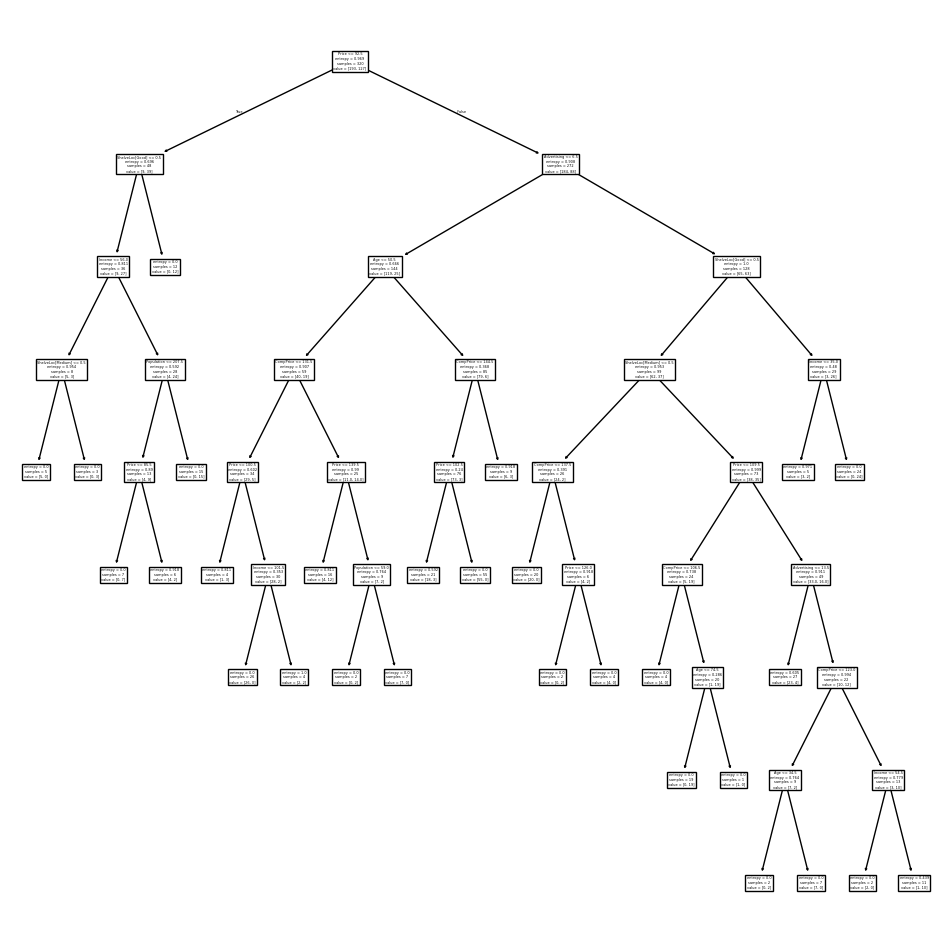

In [17]:
# Lets take a look at the pruned tree
ax = subplots(figsize = (12, 12))[1]
best_ = grid.best_estimator_
plot_tree(best_,
          feature_names = feature_names,
          ax = ax);

In [18]:
# With large trees like the one above we can count the number of terminal nodes, or query best_ instead.
best_.tree_.n_leaves

np.int64(28)

The tree with 28 terminal nodes results in the lowest cross-validation error rate with an accuracy of 77.5%

In [19]:
# We will now check how our pruned tree performs on our hold-out testing dataset
accuracy_score(High_test,
               best_.predict(X_test))

0.75

In [20]:
# This is an extra step that can be taken after the cross-validation process. We are using 'new' data (data not used in the cross_validation process) to double check the test error
confusion = confusion_table(best_.predict(X_test),
                            High_test)
confusion

Truth,No,Yes
Predicted,,
No,35,12
Yes,8,25


# Question 2
What is our estimate of the test error on this hold-out test subset?  First use the output from accuracy_score and then compute directly from the confusion table.

Our estimate of the test error on this hold-out test subset is 25% from accuracy_score and when we manually compute it straight from the confusion table we get 60 correct classifications out of 80 which is also a test error rate of 25%.

In [21]:
# Now lets try to build a classification tree to predict the shelf location using all other variables as predictors
model = MS(Carseats.columns.drop('ShelveLoc'), intercept = False)
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)

In [22]:
clf = DTC(criterion = 'entropy',
          max_depth = 3,
          random_state = 0)
clf.fit(X, Carseats['ShelveLoc'])

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [23]:
(X_train,
 X_test,
 ShelveLoc_train,
 ShelveLoc_test) = skm.train_test_split(X,
                                   Carseats['ShelveLoc'],
                                   test_size = 0.2,
                                   random_state = 0)

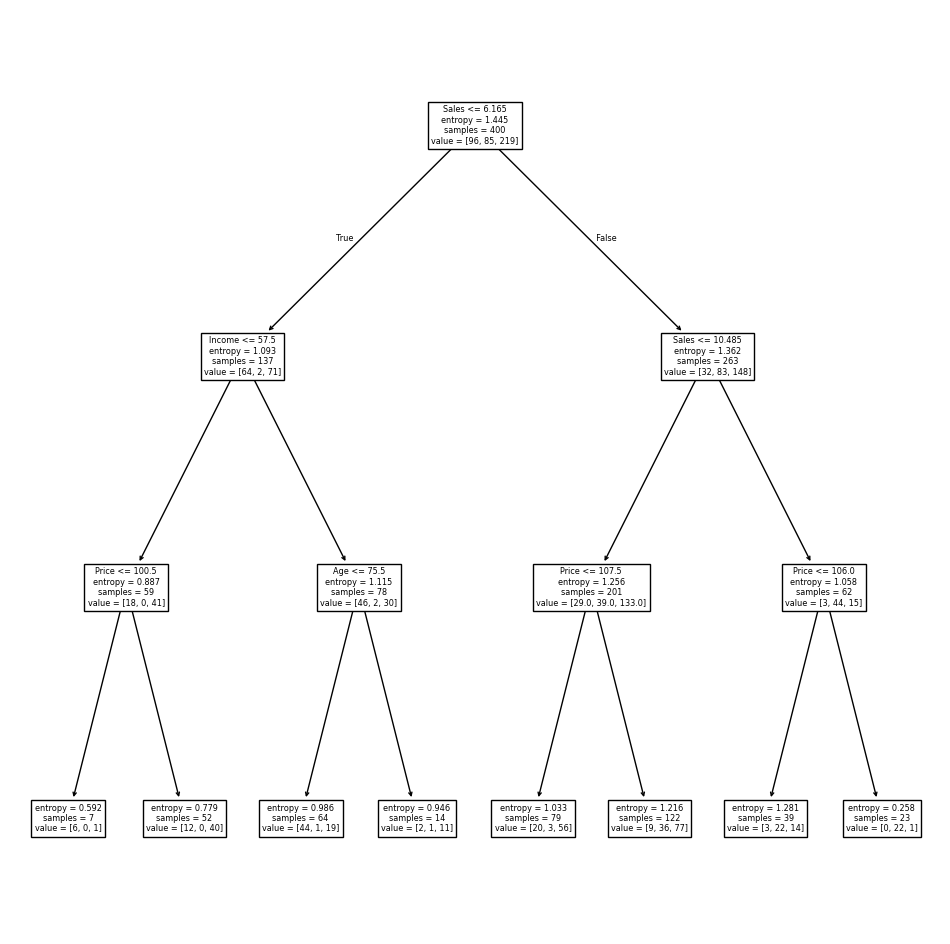

In [24]:
ax = subplots(figsize = (12, 12))[1]
plot_tree(clf,
          feature_names = feature_names,
          ax = ax);

In [25]:
ccp_path = clf.cost_complexity_pruning_path(X_train, ShelveLoc_train)
kfold = skm.KFold(10,
                  random_state = 1,
                  shuffle = True)

In [26]:
grid = skm.GridSearchCV(clf,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit = True,
                        cv = kfold,
                        scoring = 'accuracy')
grid.fit(X_train, ShelveLoc_train)
grid.best_score_

np.float64(0.65)

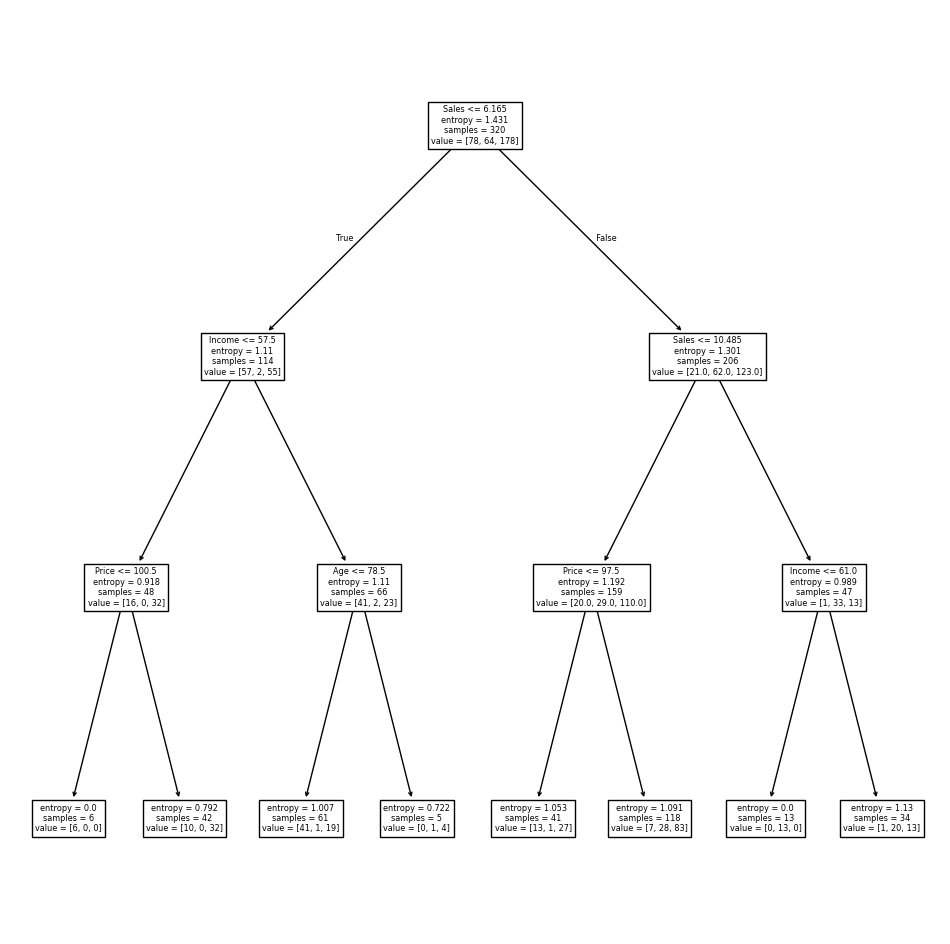

In [27]:
ax = subplots(figsize = (12, 12))[1]
best_ = grid.best_estimator_
plot_tree(best_,
          feature_names = feature_names,
          ax = ax);

In [28]:
best_.tree_.n_leaves

np.int64(8)

In [29]:
accuracy_score(ShelveLoc_test,
               best_.predict(X_test))

0.6

In [30]:
confusion = confusion_table(best_.predict(X_test),
                            ShelveLoc_test)
confusion

Truth,Bad,Good,Medium
Predicted,,,
Bad,5,0,7
Good,2,11,2
Medium,11,10,32


# Question 3
Provide a full interpretation for your pruned tree.  Make sure to also tell me how many terminal nodes it has and its estimated test error

My pruned tree to try and predict the shelf location of a carseat had a test error rate of 40% and had 8 terminal nodes.  The first split was made using sales at 6,165 which makes sense as stores would want their most popular (highest sales) carseats in the best shelve locations so they could potentially sell more.  If we go to the left our next split is made using income at 57.5 while the right side is split using sales again this time at 10,485.  The third and final splits either have to do with price, age, or income based on which way you go first.

In [31]:
# Here we fit a regression tree to the Boston dataset. We will once again be trying to estimate medv, the median value in thousands of owner-occupied homes.
Boston = load_data('Boston')
model = MS(Boston.columns.drop('medv'), intercept = False)
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)

In [32]:
# First we split the data into training and testing datasets and fit the tree to the training data. Here we will use a 70/30 split for the train/test datasets.
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                Boston['medv'],
                                test_size = 0.3,
                                random_state = 0)

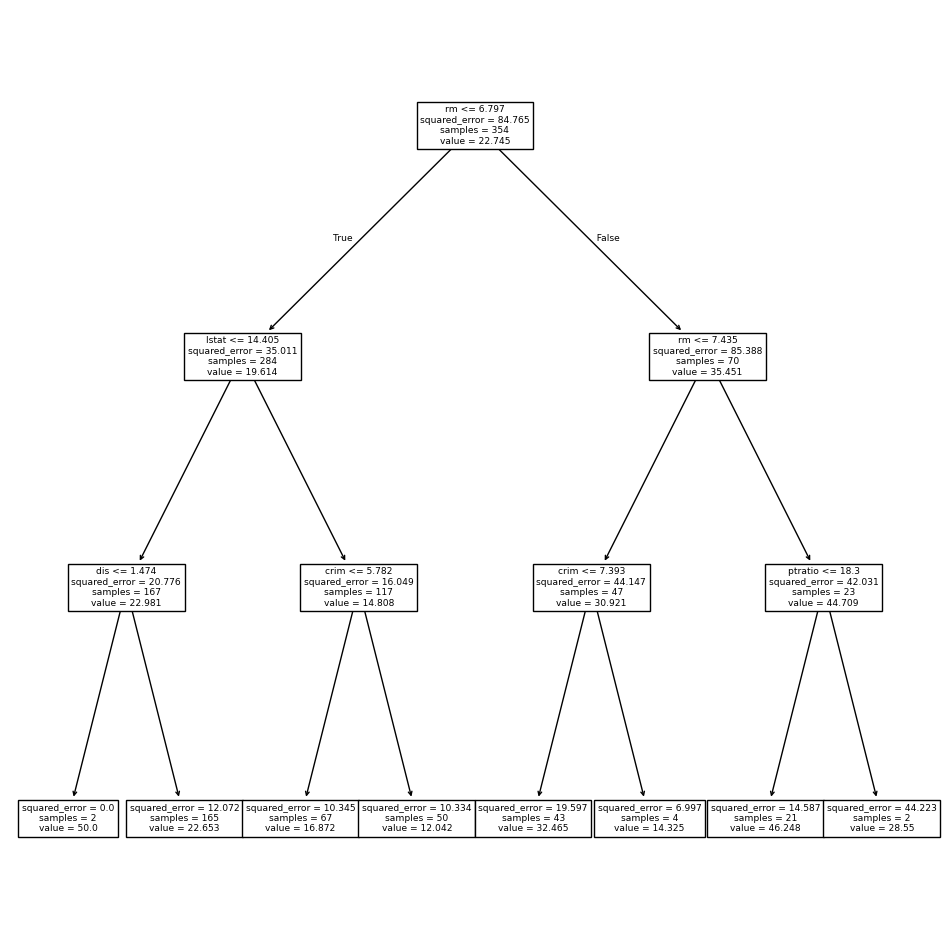

In [33]:
# Having formed our training and testing datasets we will now fit the regression tree
reg = DTR(max_depth = 3)
reg.fit(X_train, y_train)
ax = subplots(figsize = (12, 12))[1]
plot_tree(reg,
          feature_names = feature_names,
          ax = ax);

# Question 4
Provide a full interpretation for the tree displayed

Put interpretation here

In [34]:
# Now we can use cross-validation to determine the optimal tree size
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
                  shuffle = True,
                  random_state = 10)
grid = skm.GridSearchCV(reg,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit = True,
                        cv = kfold,
                        scoring = 'neg_mean_squared_error',)
G = grid.fit(X_train, y_train)

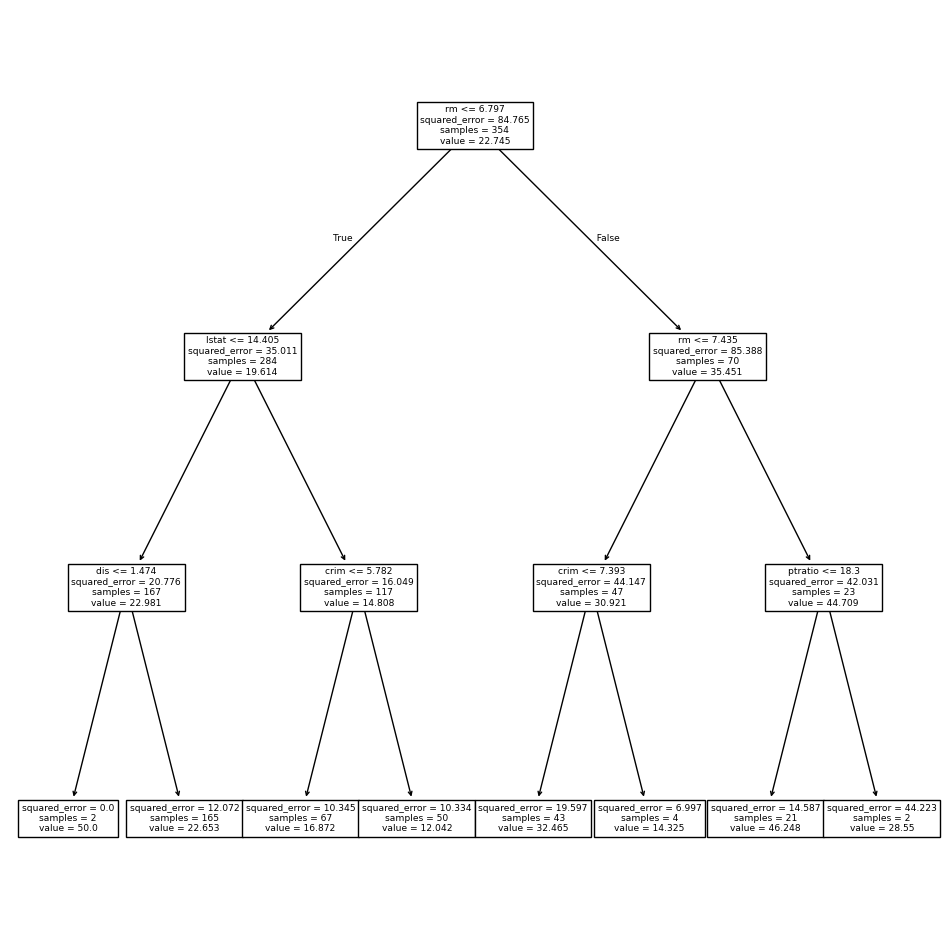

In [35]:
ax = subplots(figsize = (12, 12))[1]
best_ = grid.best_estimator_
plot_tree(best_,
          feature_names = feature_names,
          ax = ax);

In [36]:
MSE = np.mean((y_test - best_.predict(X_test)) ** 2)
MSE

np.float64(28.06985754975404)

In [37]:
RSE = np.sqrt(MSE)
RSE

np.float64(5.2980994280736216)

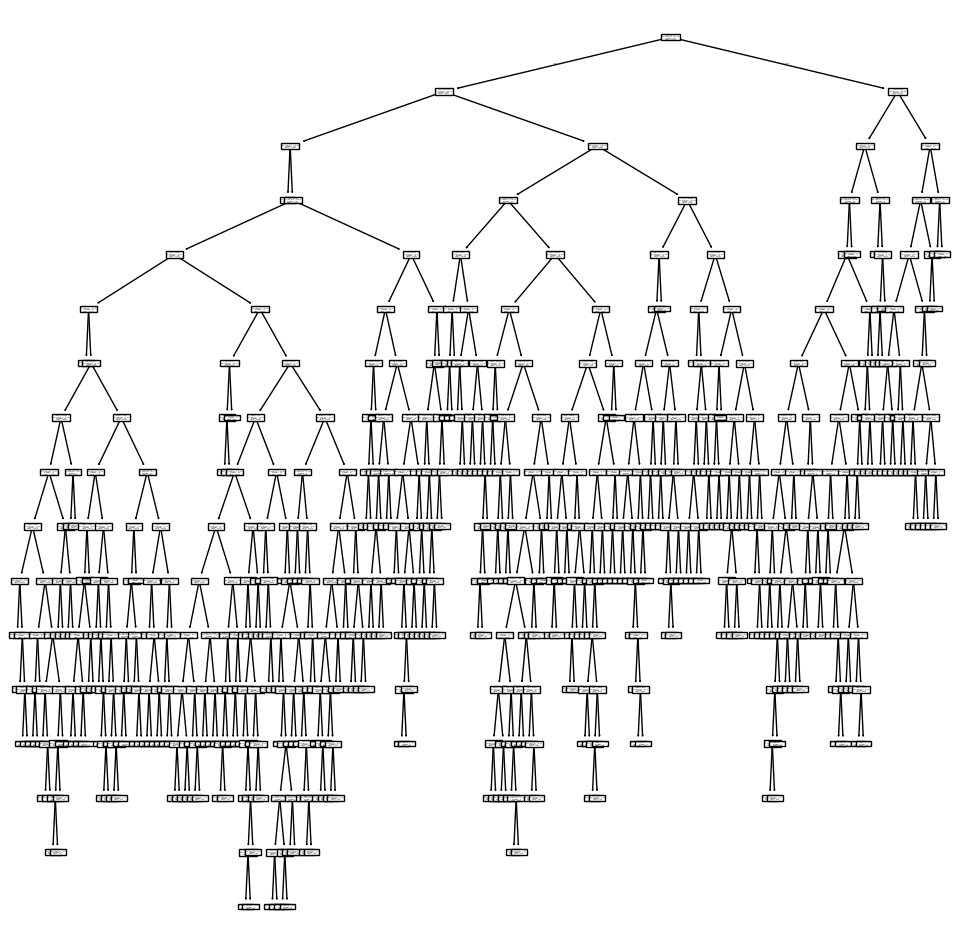

In [38]:
reg = DTR()
reg.fit(X_train, y_train)
ax = subplots(figsize = (12, 12))[1]
plot_tree(reg,
          feature_names = feature_names,
          ax = ax);

In [39]:
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
                  shuffle = True,
                  random_state = 10)
grid = skm.GridSearchCV(reg,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit = True,
                        cv = kfold,
                        scoring = 'neg_mean_squared_error')
G = grid.fit(X_train, y_train)

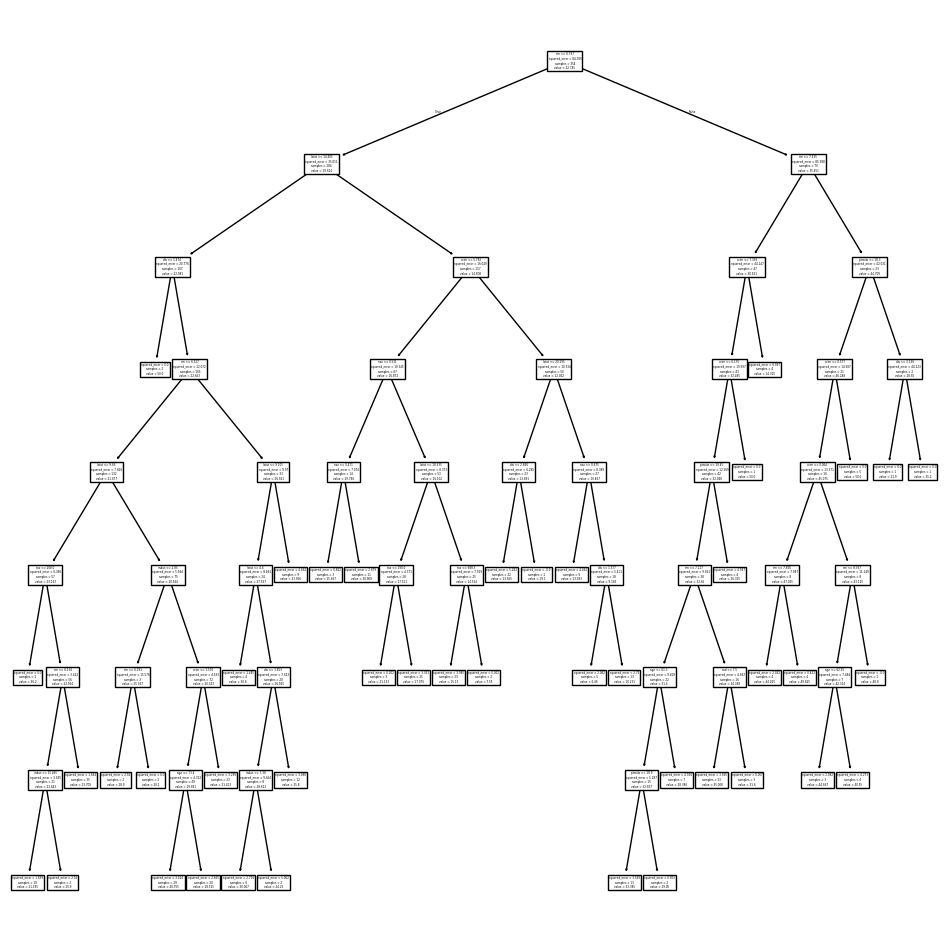

In [40]:
ax = subplots(figsize = (12, 12))[1]
best_ = grid.best_estimator_
plot_tree(best_,
          feature_names = feature_names,
          ax = ax);

In [41]:
MSE = np.mean((y_test - best_.predict(X_test)) ** 2)
MSE

np.float64(24.375465677787776)

In [42]:
RSE = np.sqrt(MSE)
RSE

np.float64(4.937151575330433)

# Question 5
Did either tree need pruning? If so how far? Interpret the RSE for the tree with the lowest test error.

Our first tree did not need any pruning, the second tree did need some pruning. After we pruned the second tree the test MSE went down by about 4, which is a good indication that we have a better model. Our RSE for the tree with the lowest test error was 4.970 which means that on average we were usually within 5 thousand of the actual median value of the house we are looking at.

In [43]:
bag_boston = RF(max_features = X_train.shape[1], random_state = 0)
bag_boston.fit(X_train, y_train)

RandomForestRegressor(max_features=12, random_state=0)

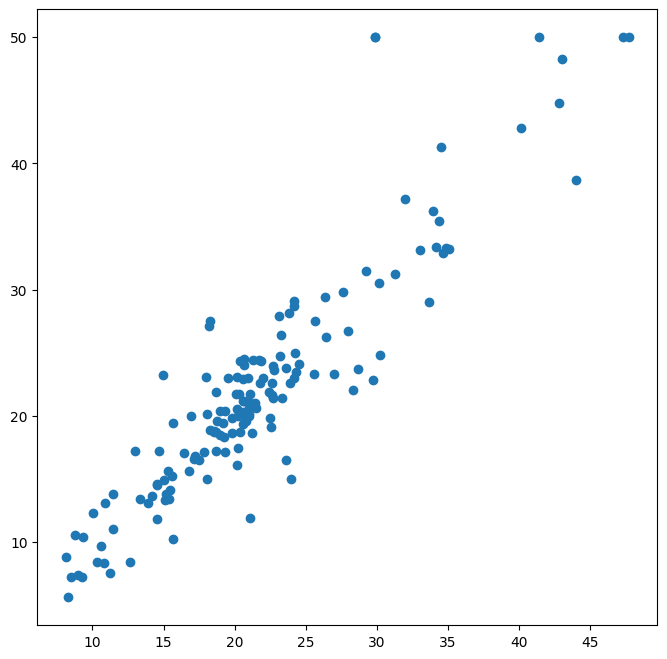

In [44]:
ax = subplots(figsize = (8, 8))[1]
y_hat_bag = bag_boston.predict(X_test)
ax.scatter(y_hat_bag, y_test)

In [45]:
MSE = np.mean((y_test - y_hat_bag) ** 2)
MSE

np.float64(14.634700151315787)

In [46]:
RSE = np.sqrt(MSE)
RSE

np.float64(3.8255326624296107)

In [47]:
bag_boston = RF(max_features = X_train.shape[1],
                n_estimators = 500,
                random_state = 0).fit(X_train, y_train)
y_hat_bag = bag_boston.predict(X_test)

MSE = np.mean((y_test - y_hat_bag) ** 2)
print(MSE)
RSE = np.sqrt(MSE)
print(RSE)

14.605662565263161
3.821735543606224


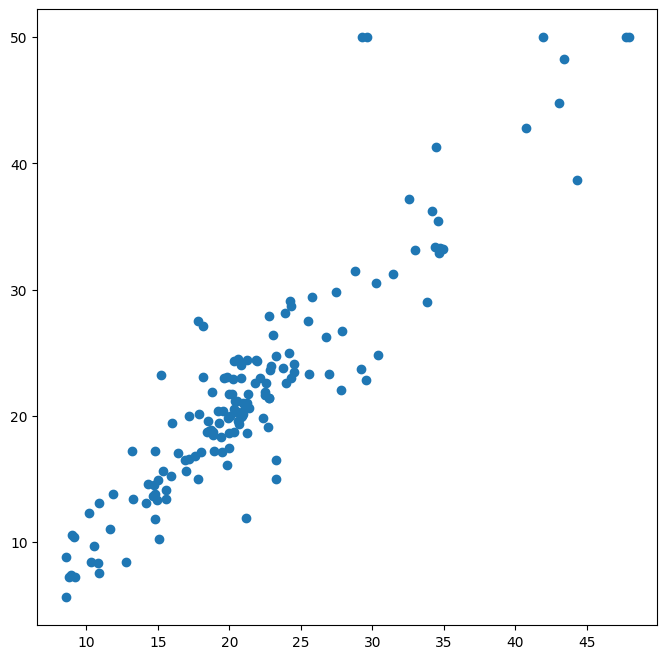

In [48]:
RF_boston = RF(max_features = 6,
               random_state = 0).fit(X_train, y_train)
y_hat_RF = RF_boston.predict(X_test)

ax = subplots(figsize = (8, 8))[1]
y_hat_RF = bag_boston.predict(X_test)
ax.scatter(y_hat_RF, y_test)

In [49]:
MSE = np.mean((y_test - y_hat_RF) ** 2)
print(MSE)
RSE = np.sqrt(MSE)
print(RSE)

14.605662565263161
3.821735543606224


In [50]:
feature_imp = pd.DataFrame(
    {'importance': RF_boston.feature_importances_},
    index = feature_names)
feature_imp.sort_values(by = 'importance', ascending = False)

,importance
lstat,0.356203
rm,0.332163
ptratio,0.067270
crim,0.055404
indus,0.053851
dis,0.041582
nox,0.035225
tax,0.025355
age,0.021506
rad,0.004784


In [51]:
boost_boston = GBR(n_estimators = 5000,
                   learning_rate = 0.01,
                   max_depth = 3,
                   random_state = 0)
boost_boston.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, n_estimators=5000, random_state=0)

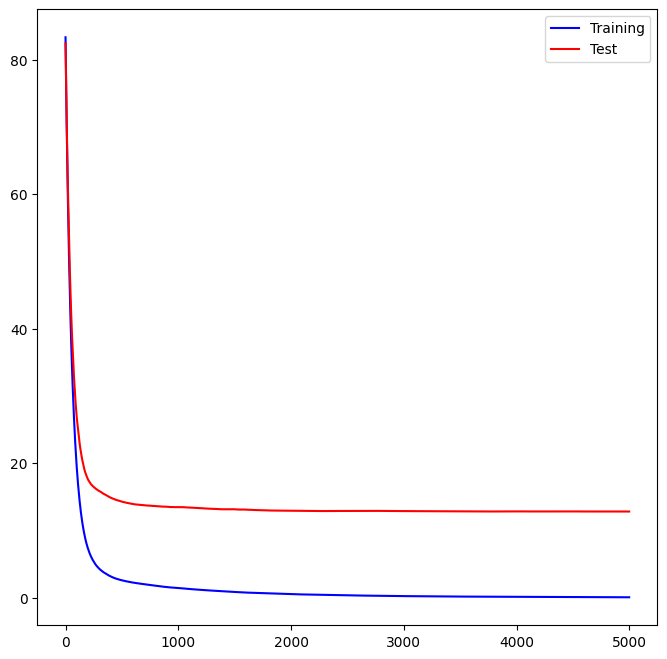

In [53]:
test_error = np.zeros_like(boost_boston.train_score_)
for idx, y_ in enumerate(boost_boston.staged_predict(X_test)):
    test_error[idx] = np.mean((y_test - y_) ** 2)

plot_idx = np.arange(boost_boston.train_score_.shape[0])
ax = subplots(figsize = (8, 8))[1]
ax.plot(plot_idx,
        boost_boston.train_score_,
        'b',
        label = 'Training')
ax.plot(plot_idx,
        test_error,
        'r',
        label = 'Test')
ax.legend();

In [55]:
y_hat_boost = boost_boston.predict(X_test)

MSE = np.mean((y_test - y_hat_boost) ** 2)
print(MSE)
RSE = np.sqrt(MSE)
print(RSE)

12.80394551228834
3.578260123619905


In [56]:
boost_boston = GBR(n_estimators = 5000,
                   learning_rate = 0.2,
                   max_depth = 3,
                   random_state = 0)
boost_boston.fit(X_train,
                 y_train)
y_hat_boost = boost_boston.predict(X_test)

MSE = np.mean((y_test - y_hat_boost) ** 2)
print(MSE)
RSE = np.sqrt(MSE)
print(RSE)

14.501514553719565
3.8080854183854074


# Question 6
Now try using the default value of 0.001 for lambda.  You should find that slowing down the learning rate actually improves your model predictions! Comment on your results.